# Amplitude-based kNN for multi-dimensional vectors

## Let's try to get the kNN working on the Iris Data Set

In [69]:
import qiskit;
# qiskit.__qiskit_version__

In [70]:
from qiskit import IBMQ
provider = IBMQ.load_account()

/home/mariano/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [71]:
print("Available backends:")
provider.backends()

Available backends:


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [72]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > 8 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


In [73]:
import numpy as np
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram

In [74]:
# The multi-controlled RY is not included in the standard gates
import qiskit.aqua.circuits.gates.controlled_ry_gates

# Initial state preparation

The algorithm starts with the assumption that the following initial state can be constructed from $M$ training vectors with $N$ entries: 
$$|\psi_0> = \frac{1}{\sqrt{2M}} \sum_{m=1}^M \big(|0>|\psi_x> + |1>|\psi_{t^m}>\big) |c^m> |m> $$
In our case, the Iris Data Set contains $M=150$ training vectors with $N=4$ entries. 

We can use less training vectors, depending on how many qubits we want to allocate to |m>: 

||m> qubits|training vectors|
|--------|----------------|
|0|$2^0=1$|
|1|$2^1=2$|
|2|$2^2=4$|
|3|$2^3=8$|
|4|$2^4=16$|
|5|$2^5=32$|
|6|$2^6=64$|
|7|$2^7=128$|
|8|$2^8=256$|

Let's start by simply upgrading the previous test and use 2 qubits for 3 training vectors. 

We will also need to consider three classes, so two qubits for |c>.

## Build the base circuit

$$|\chi_0> = |a_\text{kNN}> |d> |c> |m> = |0>|00>|00>|00>$$

In [75]:
knna = QuantumRegister(1, 'knna') # Ancilla for kNN
qrama = QuantumRegister(5, 'qrama') # Ancilla for QRAM
d = QuantumRegister(2, 'd') # Data vectors
r = QuantumRegister(1, 'r') # Rotation register for QRAM
c = QuantumRegister(2, 'class') # Class for kNN
m = QuantumRegister(2, 'm') # Index for kNN
classical = ClassicalRegister(4, 'classic')
circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)

The sum over $m$ is introduced by simply acting an $H^{\otimes2}$ gate on the $m$ qubit:
$$|\chi_1> = (\mathbb{1} \otimes \mathbb{1}^{\otimes2} \otimes \mathbb{1}^{\otimes2} \otimes H^{\otimes2}) |0>|00>|00>|00> = \frac{1}{2} \sum_{m=0}^3 |0>|00>|00>|m>.$$

In [76]:
circuit.h(m)
# circuit.draw()

Using another H gate, the ancilla qubit is put in superposition: 
$$|\chi_2> = (H \otimes \mathbb{1}^{\otimes2} \otimes \mathbb{1}^{\otimes2} \otimes \mathbb{1}^{\otimes2}) |\chi_1> = \frac{1}{2\sqrt{2}} \sum_{m=0}^3 \big[|0>|00> + |1>|00>\big]|00>|m>$$

In [77]:
circuit.h(knna)
# circuit.draw()

Next, the input vector $|\psi_x>$ should be loaded into the quantum state by means of QRAM construction
$$|\chi_3> = QRAM(x) |\chi_2>$$

The probability of getting |R=1> is $\sum_{l=0}^{M-1} |\psi_{\vec{d^{(l)}}} \sin{\theta^{(l)}}|^2$, where l is our training vector index; that means we should translate our training vectors in rotation angles of the states. 

It is reasonable to transform the vectors in this way: we take the maximal value of the entries and map that to a rotation of π/2 degrees. 

### Errors below: π should be π/2
|entry 1|entry 2|entry 3|entry 4|normalized 1|normalized 2|normalized 3|normalized 4|class|
|-------|-------|-------|-------|------------|------------|------------|------------|-----|
|5.1    |3.5    |1.4    |0.2    |2.2889      |1.5708      |0.6283      |0.0898      |0    |
|7.0    |3.2    |4.7    |1.4    |π = 3.1416  |1.4362      |2.1094      |0.6283      |1    |
|6.3    |3.3    |6.0    |2.5    |2.8274      |1.481       |2.6928      |1.122       |2    |

The maximal value found it this test set is 7.0: its normalised value will be π. 

It is questionable wether the mapping should be linear or follow the sine function. 

In [78]:
# round(np.pi/7.0*2.5,4)

In [79]:
# Put |d> in superposition
circuit.h(d)

In [80]:
inputVector = [np.pi/2,0,0,0] # Classical data vector with max at π/2
setosa = [np.pi/7.0*5.1/2, np.pi/7.0*3.5/2, np.pi/7.0*1.4/2, np.pi/7.0*0.2/2]
versicolor = [np.pi/2, np.pi/7.0*3.2/2, np.pi/7.0*4.7/2, np.pi/7.0*1.4/2]
virginica = [np.pi/7.0*6.3/2, np.pi/7.0*3.3/2, np.pi/7.0*6.0/2, np.pi/7.0*2.5/2]
# Let's put in one of the training vectors first, then we will use a different vector from the Data Set

In [81]:
# circuit.mct?

In [82]:
xVector = setosa
# Begin QRAM state construction for two qubit data, class and m
# Not being entangled with class and m, we can leave it unmodified
psixCircuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψx state to the |0> state of the kNN ancilla

# Encode state |00>
psixCircuit.x(d)
# The rotation angle should be converted accordingly: the max should be mapped to π/2
psixCircuit.mcry(xVector[0], d[0:] + knna[0:], r[0], qrama)
psixCircuit.x(d)
# psixCircuit.barrier()

# Encode state |01>
psixCircuit.x(d[1])
psixCircuit.mcry(xVector[1], d[0:] + knna[0:], r[0], qrama)
psixCircuit.x(d[1])
# psixCircuit.barrier()

# Encode state |10>
psixCircuit.x(d[0])
psixCircuit.mcry(xVector[2], d[0:] + knna[0:], r[0], qrama)
psixCircuit.x(d[0])
# psixCircuit.barrier()

# Encode state |11>
psixCircuit.mcry(xVector[3], d[0:] + knna[0:], r[0], qrama)
# psixCircuit.barrier()

# Switch entanglement with ancilla to |a> = |0>
psixCircuit.x(knna)

# psixCircuit.draw(output='mpl')

In [83]:
circuit += psixCircuit

$$|\chi_3> = \frac{1}{2} \sum_{m=0}^1 \big[ |0>|\psi_x> + |1>|00> \big] |0> |m>$$

The next step is to entangle the first training vector $|\psi_{t^0}>$ with the $|1>$ state of the ancilla and the $|0>$ state of the $m$ qubit. Additionally, the second training vector $\psi_{t^1}$ should be entangled with the $|1>$ states of the ancilla and of the $m$ qubit. 

In [84]:
circuit.h(c)

In [85]:
trainingVector0 = setosa
# Entangled with |c> = |00>, |m> = |00>

In [86]:
# Begin QRAM state construction for two qubit data, class and m
# Now we have more things to consider
# This is the first training vector: |m>=|00>, |c>=|00>
# We should apply two x to m and two x to c at the start and at the end
psit0Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt0 state to the |1> state of the kNN ancilla, to the |00> state of m and to the |00> state of c
# Do I need to superposition |d> again? No
# I also need to entangle the class of the training vector; that should be encoded in the classical vector

# psit0Circuit.x(c)
# psit0Circuit.x(m)

# Encode state |00>
psit0Circuit.x(d)
psit0Circuit.mcry(trainingVector0[0], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit0Circuit.x(d)
# psit0Circuit.barrier()

# Encode state |01>
psit0Circuit.x(d[1])
psit0Circuit.mcry(trainingVector0[1], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit0Circuit.x(d[1])
# psit0Circuit.barrier()

# Encode state |10>
psit0Circuit.x(d[0])
psit0Circuit.mcry(trainingVector0[2], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit0Circuit.x(d[0])
# psit0Circuit.barrier()

# Encode state |11>
psit0Circuit.mcry(trainingVector0[3], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
# psit0Circuit.barrier()

# Switch entanglement with m to |m> = |00>
psit0Circuit.x(m)
# Switch entanglement with c to |c> = |00>
psit0Circuit.x(c)

# psit0Circuit.draw(output='mpl')

In [87]:
circuit += psit0Circuit

In [88]:
trainingVector1 = versicolor
# Entangled with |c> = |01>, |m> = |01>

In [89]:
# Begin QRAM state construction for two qubit data
psit1Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt1 state to the |1> state of the kNN ancilla, to the |01> state of m and to the |01> state of c

# psit1Circuit.x(c[1])
# psit1Circuit.x(m[1])

# Encode state |00>
psit1Circuit.x(d)
psit1Circuit.mcry(trainingVector1[0], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit1Circuit.x(d)
# psit1Circuit.barrier()

# Encode state |01>
psit1Circuit.x(d[1])
psit1Circuit.mcry(trainingVector1[1], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit1Circuit.x(d[1])
# psit1Circuit.barrier()

# Encode state |10>
psit1Circuit.x(d[0])
psit1Circuit.mcry(trainingVector1[2], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit1Circuit.x(d[0])
# psit1Circuit.barrier()

# Encode state |11>
psit1Circuit.mcry(trainingVector1[3], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
# psit1Circuit.barrier()

psit1Circuit.x(c[1])
psit1Circuit.x(m[1])

# psit1Circuit.draw(output='mpl')

In [90]:
circuit += psit1Circuit

In [91]:
trainingVector2 = virginica
# Entangled with |c> = |10>, |m> = |10>

In [92]:
# Begin QRAM state construction for two qubit data
psit2Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt1 state to the |1> state of the kNN ancilla, to the |10> state of m and to the |10> state of c

# psit2Circuit.x(c[0])
# psit2Circuit.x(m[0])

# Encode state |00>
psit2Circuit.x(d)
psit2Circuit.mcry(trainingVector2[0], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit2Circuit.x(d)
# psit2Circuit.barrier()

# Encode state |01>
psit2Circuit.x(d[1])
psit2Circuit.mcry(trainingVector2[1], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit2Circuit.x(d[1])
# psit2Circuit.barrier()

# Encode state |10>
psit2Circuit.x(d[0])
psit2Circuit.mcry(trainingVector2[2], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
psit2Circuit.x(d[0])
# psit2Circuit.barrier()

# Encode state |11>
psit2Circuit.mcry(trainingVector2[3], d[0:] + knna[0:] + m[0:] + c[0:], r[0], qrama)
# psit2Circuit.barrier()

psit2Circuit.x(c[0])
psit2Circuit.x(m[0])

# psit2Circuit.draw(output='mpl')

In [93]:
circuit += psit2Circuit

The desired input and training state is obtained after post-selecting the measurement outcome $|1>_R$ on the register qubit.

In [94]:
circuit.measure(r,classical[0])

Having prepared the initial state $|\psi_0>$ one has to simply apply an H gate to the ancilla qubit. This causes the aplitudes of $|\psi_x>$ and $|\psi_{t^m}>$ to interfere. In this case, constructive ($+$) interference happens when the ancilla qubit is $|0>$ and destructive ($-$) interference when the ancilla is $|1>$. 

In [95]:
circuit.h(knna)
circuit.measure(knna,classical[1])

After the successful conditional measurement, the state is proportional to:
$$|\psi_2> = \frac{1}{2\sqrt{M}} \sum_{m=0}^1 \sum_{i=0}^3 (x_i + t_i^m) |0> |i> |c^m> |m>$$

The probability of measuring e.g. class $|1>$ (B) is then given by the following expression:
$$\text{Prob}(|c^m> = |1(\text{B})>) = \sum_{m|c^m=1(\text{B})} 1 - \frac{1}{4M} \sum_{i=0}^3 |x_i - t_i^m|^2$$

In [96]:
circuit.measure(c[0],classical[2])
circuit.measure(c[1],classical[3])

In [143]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=2048)
result = job.result()
counts = result.get_counts(circuit)
# print("\nTotal counts are:",counts)

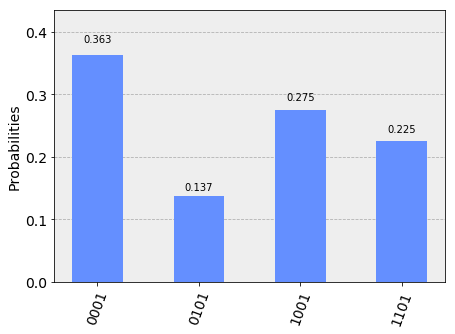

In [144]:
# c[0] = |R> should be |1>
# c[1] = |a> should be |0>
goodCounts = {k: counts[k] for k in counts.keys() & {'0001', '0101', '1001', '1101'}}
plot_histogram(goodCounts)

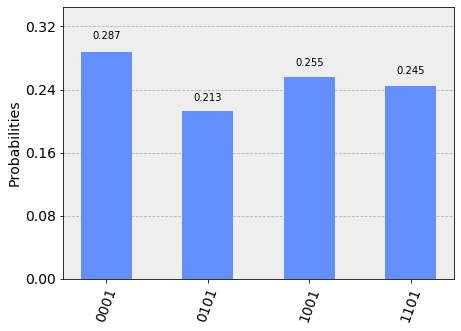

In [66]:
# old with mistake
# c[0] = |R> should be |1>
# c[1] = |a> should be |0>
goodCounts = {k: counts[k] for k in counts.keys() & {'0001', '0101', '1001', '1101'}}
plot_histogram(goodCounts)

In [113]:
from qiskit.tools.monitor import job_monitor
# Number of shots to run the program (experiment);
# maximum is 8192 shots.
shots = 2048
# Maximum number of credits to spend on executions.
max_credits = 3

job_exp = execute(circuit, backend, shots=shots, max_credits=max_credits)
job_monitor(job_exp)

Job Status: job is actively running 

JobError: '520 Server Error: Origin Error for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/5d5d0a14600e30001904615c/status?access_token=...'

In [115]:
# Remember to give different names to different runs
result_exp = job_exp.result()

In [116]:
counts_exp = result_exp.get_counts(circuit)

In [117]:
goodCounts_exp = {k: counts_exp[k] for k in counts_exp.keys() & {'0001', '0101', '1001', '1101'}}

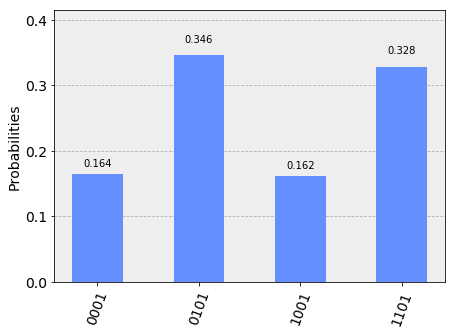

In [118]:
plot_histogram(goodCounts_exp)

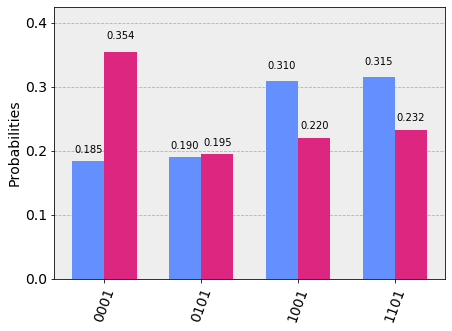

In [42]:
# old with mistakes
# First run with simple orthogonal training vectors
# Id 5d40aef179d2c1001849f56b
plot_histogram([goodCounts_exp,goodCounts])

In [72]:
# Remember to give different names to different runs
result_exp_1 = job_exp.result()

In [73]:
counts_exp_1 = result_exp_1.get_counts(circuit)

In [74]:
goodCounts_exp_1 = {k: counts_exp_1[k] for k in counts_exp_1.keys() & {'0001', '0101', '1001', '1101'}}

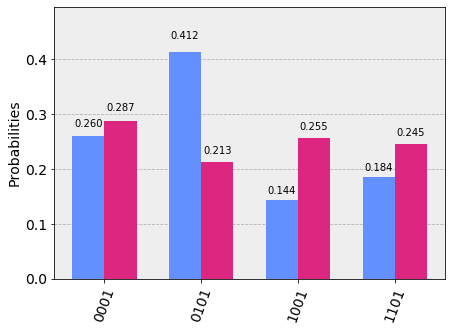

In [75]:
# First run with simple orthogonal training vectors
# Id 5d40aef179d2c1001849f56b
plot_histogram([goodCounts_exp_1,goodCounts])

In [154]:
backend_hpc = provider.get_backend('ibmq_qasm_simulator', hub=None)

In [155]:
# Number of shots to run the program (experiment);
# maximum is 8192 shots.
shots = 2048

# Maximum number of credits to spend on executions.
max_credits = 3

job_hpc = execute(circuit, backend_hpc, shots=shots, max_credits=max_credits)

In [156]:
result_hpc = job_hpc.result()

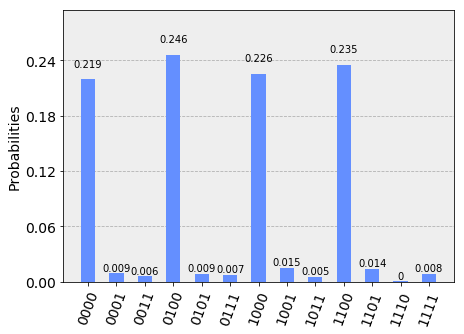

In [157]:
counts_hpc = result_hpc.get_counts(circuit)
plot_histogram(counts_hpc)

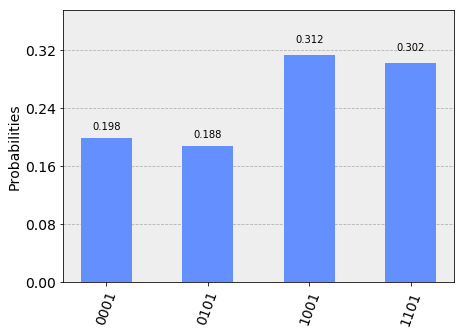

In [158]:
goodCounts_hpc = {k: counts_hpc[k] for k in counts_hpc.keys() & {'0001', '0101', '1001', '1101'}}
plot_histogram(goodCounts_hpc)

In [ ]:
# Number of shots to run the program (experiment);
# maximum is 8192 shots.
shots = 2048
# Maximum number of credits to spend on executions.
max_credits = 3

job_exp_ibmq_qasm = execute(circuit, 'ibmq_qasm_simulator', shots=shots, max_credits=max_credits)
job_monitor(job_exp_ibmq_qasm)

In [227]:
# # Testing QRAM
# inputVector = [np.pi,np.pi,np.pi,0]
# qram = QuantumCircuit(qrama,d,r,classical)
# # I need to entangle the ψx state to the |0> state of the kNN ancilla
# qram.h(d)
# # Encode state |00>
# qram.x(d)
# # The rotation angle should be converted accordingly
# qram.mcry(inputVector[0], d[0:2], r[0], qrama)
# qram.x(d)
# qram.barrier()
# # Encode state |01>
# qram.x(d[0])
# qram.mcry(inputVector[1], d[0:2], r[0], qrama)
# qram.x(d[0])
# qram.barrier()
# # Encode state |10>
# qram.x(d[1])
# qram.mcry(inputVector[2], d[0:2], r[0], qrama)
# qram.x(d[1])
# qram.barrier()
# # Encode state |11>
# qram.mcry(inputVector[3], d[0:2], r[0], qrama)
# qram.barrier()
# # qram.draw(output='mpl')
# qram.measure(r,classical[0])
# simulator = Aer.get_backend('qasm_simulator')
# job = execute(qram, simulator, shots=2000)
# result = job.result()
# counts = result.get_counts(qram)
# print("\nTotal counts are:",counts)

In [228]:
# # Testing qubits order
# qreg = QuantumRegister(2, 'qreg')
# creg = ClassicalRegister(2, 'creg')
# test = QuantumCircuit(qreg,creg)
# test.x(qreg[0])
# test.h(qreg[1])
# test.measure(qreg,creg)
# tester = Aer.get_backend('qasm_simulator')
# jobber = execute(test, tester, shots=1024)
# resulter = jobber.result()
# counter = resulter.get_counts(test)
# print("Total counts are:",counter)
# # So the 0th place of a vector is the rightmost in the bracket representation

In [379]:
# ancillae = QuantumRegister(2)
# qubits = QuantumRegister(3)
# bits = ClassicalRegister(5)
# rotation = QuantumCircuit(ancillae,qubits,bits)

In [380]:
# rotation.mcry(np.pi,qubits[0:2],qubits[2],ancillae)
# rotation.x(ancillae)
# rotation.h(qubits)
# rotation.measure(ancillae,bits[0:2])
# rotation.measure(qubits,bits[2:])

In [381]:
# simulator = Aer.get_backend('qasm_simulator')
# job = execute(rotation, simulator, shots=1024)
# result = job.result()
# counts = result.get_counts(rotation)
# print("Total counts are:",counts)

Total counts are: {'00111': 121, '11111': 121, '00011': 134, '01011': 122, '01111': 135, '10111': 127, '10011': 123, '11011': 141}
